<a href="https://colab.research.google.com/github/yisi22/Real-Estate-Investment/blob/main/CondoPricing_D9%2C10%2C11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [828]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks
from datetime import datetime
import math
from functools import reduce
import requests
import json
from dateutil.relativedelta import relativedelta

In [829]:
# !pip install geopy
# !pip install python-dateutil

In [830]:
data = pd.read_csv('/content/ResidentialTransaction_D9,10,11_2009to2023.csv', encoding = 'latin1')

In [831]:
data

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Tenure,Completion Date,Postal District,Postal Sector,Planning Area
0,PARK INFINIA AT WEE NAM,"1,103,000","1,001.05","1,102",06-Mar-09,2A LINCOLN ROAD #14-07,Freehold,2008,11,30,Novena
1,PARK INFINIA AT WEE NAM,"1,220,000","1,001.05","1,219",12-Mar-09,2A LINCOLN ROAD #24-07,Freehold,2008,11,30,Novena
2,PARK INFINIA AT WEE NAM,"1,139,000","1,001.05","1,138",13-Mar-09,2A LINCOLN ROAD #22-07,Freehold,2008,11,30,Novena
3,PARK INFINIA AT WEE NAM,"1,902,000","1,463.90","1,299",20-Mar-09,2A LINCOLN ROAD #02-08,Freehold,2008,11,30,Novena
4,THE SUITES AT CENTRAL,"908,262",635.08,"1,430",20-Mar-09,57A DEVONSHIRE ROAD #19-02,Freehold,2009,9,23,River Valley
...,...,...,...,...,...,...,...,...,...,...,...
10017,WATTEN HOUSE,"14,391,000","4,079.56","3,520",14-Dec-23,46 SHELFORD ROAD #05-27,Freehold,Uncompleted,11,28,Bukit Timah
10018,CUSCADEN RESERVE,"3,537,000",936.47,"3,777",17-Dec-23,8 CUSCADEN ROAD #23-06,99 yrs from 14/08/2018,2023,10,24,Orchard
10019,WATTEN HOUSE,"6,054,000","1,851.41","3,270",18-Dec-23,38 SHELFORD ROAD #01-09,Freehold,Uncompleted,11,28,Bukit Timah
10020,WATTEN HOUSE,"4,976,000","1,539.25","3,233",22-Dec-23,44 SHELFORD ROAD #02-20,Freehold,Uncompleted,11,28,Bukit Timah


## Find Location

In [832]:
def find_postal(lst, filename):
    '''With the block number and street name, get the full address of the hdb flat,
    including the postal code, geographical coordinates (lat/long)'''

    file = pd.DataFrame()  # Initialize an empty DataFrame

    for index, add in enumerate(lst):
        url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={add}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
        print(index, url)

        try:
            response = requests.get(url)
            data = json.loads(response.text)
        except ValueError:
            print('JSONDecodeError')
            continue  # Skip to the next iteration in case of JSONDecodeError

        temp_df = pd.DataFrame.from_dict(data["results"])
        temp_df["address"] = add

        if index == 0:
            file = temp_df
        else:
            file = pd.concat([file, temp_df], ignore_index=True)

    file.to_csv(filename + '.csv', index=False)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

In [833]:
building_name = data['Project Name'].unique()
find_postal(building_name,'Location')

0 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=PARK INFINIA AT WEE NAM&returnGeom=Y&getAddrDetails=Y&pageNum=1
1 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=THE SUITES AT CENTRAL&returnGeom=Y&getAddrDetails=Y&pageNum=1
2 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=THE LINCOLN RESIDENCES&returnGeom=Y&getAddrDetails=Y&pageNum=1
3 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=BELLE VUE RESIDENCES&returnGeom=Y&getAddrDetails=Y&pageNum=1
4 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=VERDURE&returnGeom=Y&getAddrDetails=Y&pageNum=1
5 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=ST THOMAS SUITES&returnGeom=Y&getAddrDetails=Y&pageNum=1
6 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=MARTIN PLACE RESIDENCES&returnGeom=Y&getAddrDetails=Y&pageNum=1
7 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=THE WHARF RESIDENCE&returnGeom=Y&getAddrDetails=Y&pageNum=1
8 https:/

In [834]:
location_result = pd.read_csv('Location.csv')

In [835]:
# check file location
# import os

# # Replace 'your_file.csv' with the actual name of your CSV file
# file_name = 'Location.csv'

# # Get the absolute path of the current working directory
# current_directory = os.getcwd()

# # Create the full path by joining the current directory and the file name
# full_path = os.path.join(current_directory, file_name)

# # Check if the file exists
# if os.path.exists(full_path):
#     print(f"The CSV file '{file_name}' is located at: {full_path}")
# else:
#     print(f"The CSV file '{file_name}' does not exist in the current directory.")

In [836]:
building_location = location_result.groupby('BUILDING').mean(numeric_only=True)
building_location = building_location[['LATITUDE', 'LONGITUDE']].reset_index()

In [837]:
data = data.merge(building_location, left_on = 'Project Name', right_on = 'BUILDING', how = 'left')

In [838]:
mrt = pd.read_csv('/content/MRT.csv')
school = pd.read_csv('/content/School.csv')

In [839]:
find_postal(school['Address'], 'school_loc')
school_loc = pd.read_csv('school_loc.csv')

0 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=52 King's Rd&returnGeom=Y&getAddrDetails=Y&pageNum=1
1 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=9 Bishan Street 22&returnGeom=Y&getAddrDetails=Y&pageNum=1
2 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=49 Marine Cres&returnGeom=Y&getAddrDetails=Y&pageNum=1
3 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=30 Jln Lempeng&returnGeom=Y&getAddrDetails=Y&pageNum=1
4 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=2 Tampines Ave 3&returnGeom=Y&getAddrDetails=Y&pageNum=1
5 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=1 Holland Grove Rd&returnGeom=Y&getAddrDetails=Y&pageNum=1
6 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=50 Barker Rd&returnGeom=Y&getAddrDetails=Y&pageNum=1
7 https://www.onemap.gov.sg/api/common/elastic/search?searchVal=21 Hillcrest Rd&returnGeom=Y&getAddrDetails=Y&pageNum=1
8 https://www.onemap.gov.sg/api/common/el

In [840]:
data['min_distance_to_mrt'] = 0

for data_index, data_row in data.iterrows():
    loc_lat = data_row['LATITUDE']
    loc_lng = data_row['LONGITUDE']
    min_distance = float('inf')
    for mrt_index, mrt_row in mrt.iterrows():
        mrt_lat = mrt_row['lat']
        mrt_lng = mrt_row['lng']
        distance = haversine(loc_lat, loc_lng, mrt_lat, mrt_lng)
        if distance < min_distance:
            min_distance = distance

    data.at[data_index, 'min_distance_to_mrt'] = min_distance

data['min_distance_to_star_school'] = 0

for data_index, data_row in data.iterrows():
    loc_lat = data_row['LATITUDE']
    loc_lng = data_row['LONGITUDE']
    min_distance = float('inf')
    for school_index, school_row in school_loc.iterrows():
        school_lat = school_row['LATITUDE']
        school_lng = school_row['LONGITUDE']
        distance = haversine(loc_lat, loc_lng, school_lat, school_lng)
        if distance < min_distance:
            min_distance = distance

    data.at[data_index, 'min_distance_to_star_school'] = min_distance

## Find Room Type

In [841]:
data['Room Type'] = np.where(data['Area (SQFT)'].str.replace(',', '').astype('float') >1300, 5, 0)
data['Room Type'] = np.where((data['Area (SQFT)'].str.replace(',', '').astype('float') <=1300) & (data['Area (SQFT)'].str.replace(',', '').astype('float') > 1100), 4, data['Room Type'])
data['Room Type'] = np.where((data['Area (SQFT)'].str.replace(',', '').astype('float') <=1100) & (data['Area (SQFT)'].str.replace(',', '').astype('float') > 800), 3, data['Room Type'])
data['Room Type'] = np.where((data['Area (SQFT)'].str.replace(',', '').astype('float') <=800) & (data['Area (SQFT)'].str.replace(',', '').astype('float') > 600), 2, data['Room Type'])
data['Room Type'] = np.where(data['Area (SQFT)'].str.replace(',', '').astype('float') <=600, 1, data['Room Type'])
data['Sale Year'] = data['Sale Date'].str.split('-', expand = True)[2]

In [842]:
data['Sale Month'] = pd.to_datetime(data['Sale Date']).dt.to_period('M').dt.to_timestamp()

## Sale Progress

In [843]:
time_data = data.groupby('Project Name')['Sale Month'].min()

In [844]:
time_data

Project Name
368 THOMSON      2010-07-01
6 DERBYSHIRE     2013-12-01
8 NAPIER         2010-12-01
8 SAINT THOMAS   2018-08-01
ARDMORE THREE    2012-10-01
                    ...    
VAN HOLLAND      2020-01-01
VERDURE          2009-04-01
VIVA             2009-08-01
VOLARI           2009-07-01
WATTEN HOUSE     2023-11-01
Name: Sale Month, Length: 84, dtype: datetime64[ns]

In [845]:
data_new = data.merge(time_data, left_on = 'Project Name', right_index = True, how = 'left')

In [846]:
data_new = data_new.rename(columns = {'Sale Month_y' : 'Earliest Sale Month'})

In [847]:
data_new

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Tenure,Completion Date,Postal District,Postal Sector,Planning Area,BUILDING,LATITUDE,LONGITUDE,min_distance_to_mrt,min_distance_to_star_school,Room Type,Sale Year,Sale Month_x,Earliest Sale Month
0,PARK INFINIA AT WEE NAM,"1,103,000","1,001.05","1,102",06-Mar-09,2A LINCOLN ROAD #14-07,Freehold,2008,11,30,Novena,PARK INFINIA AT WEE NAM,1.314542,103.843440,0.607568,0.968993,3,09,2009-03-01,2009-03-01
1,PARK INFINIA AT WEE NAM,"1,220,000","1,001.05","1,219",12-Mar-09,2A LINCOLN ROAD #24-07,Freehold,2008,11,30,Novena,PARK INFINIA AT WEE NAM,1.314542,103.843440,0.607568,0.968993,3,09,2009-03-01,2009-03-01
2,PARK INFINIA AT WEE NAM,"1,139,000","1,001.05","1,138",13-Mar-09,2A LINCOLN ROAD #22-07,Freehold,2008,11,30,Novena,PARK INFINIA AT WEE NAM,1.314542,103.843440,0.607568,0.968993,3,09,2009-03-01,2009-03-01
3,PARK INFINIA AT WEE NAM,"1,902,000","1,463.90","1,299",20-Mar-09,2A LINCOLN ROAD #02-08,Freehold,2008,11,30,Novena,PARK INFINIA AT WEE NAM,1.314542,103.843440,0.607568,0.968993,5,09,2009-03-01,2009-03-01
4,THE SUITES AT CENTRAL,"908,262",635.08,"1,430",20-Mar-09,57A DEVONSHIRE ROAD #19-02,Freehold,2009,9,23,River Valley,THE SUITES AT CENTRAL,1.298518,103.836818,0.284591,2.211609,2,09,2009-03-01,2009-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017,WATTEN HOUSE,"14,391,000","4,079.56","3,520",14-Dec-23,46 SHELFORD ROAD #05-27,Freehold,Uncompleted,11,28,Bukit Timah,WATTEN HOUSE,1.329135,103.810917,0.493502,0.498253,5,23,2023-12-01,2023-11-01
10018,CUSCADEN RESERVE,"3,537,000",936.47,"3,777",17-Dec-23,8 CUSCADEN ROAD #23-06,99 yrs from 14/08/2018,2023,10,24,Orchard,CUSCADEN RESERVE,1.303610,103.825160,0.738780,2.010773,3,23,2023-12-01,2019-09-01
10019,WATTEN HOUSE,"6,054,000","1,851.41","3,270",18-Dec-23,38 SHELFORD ROAD #01-09,Freehold,Uncompleted,11,28,Bukit Timah,WATTEN HOUSE,1.329135,103.810917,0.493502,0.498253,5,23,2023-12-01,2023-11-01
10020,WATTEN HOUSE,"4,976,000","1,539.25","3,233",22-Dec-23,44 SHELFORD ROAD #02-20,Freehold,Uncompleted,11,28,Bukit Timah,WATTEN HOUSE,1.329135,103.810917,0.493502,0.498253,5,23,2023-12-01,2023-11-01


In [848]:
data = pd.concat([data, data_new['Earliest Sale Month']],axis=1)

In [849]:
def add_one_year(date):
    return date + relativedelta(months=12)
def add_two_year(date):
    return date + relativedelta(months=24)
def add_three_year(date):
    return date + relativedelta(months=36)
def add_four_year(date):
    return date + relativedelta(months=48)
data['Sale First Year'] = data['Earliest Sale Month'].apply(add_one_year).astype('datetime64[ns]')
data['Sale Second Year'] = data['Earliest Sale Month'].apply(add_two_year).astype('datetime64[ns]')
data['Sale Third Year'] = data['Earliest Sale Month'].apply(add_three_year).astype('datetime64[ns]')
data['Sale Fourth Year'] = data['Earliest Sale Month'].apply(add_four_year).astype('datetime64[ns]')

In [850]:
# set the date later than 2023-12-31 to 2023-12-31
data['Sale First Year'] = np.where(data['Sale First Year'] > '2023-12-31', np.datetime64('2023-12-31'), data['Sale First Year'])
data['Sale Second Year'] = np.where(data['Sale Second Year'] > '2023-12-31', np.datetime64('2023-12-31'), data['Sale Second Year'])
data['Sale Third Year'] = np.where(data['Sale Third Year'] > '2023-12-31', np.datetime64('2023-12-31'), data['Sale Third Year'])
data['Sale Fourth Year'] = np.where(data['Sale Fourth Year'] > '2023-12-31', np.datetime64('2023-12-31'), data['Sale Fourth Year'])

In [851]:
data['Sold in First Year'] = np.where((data['Sale Month'] >= data['Earliest Sale Month']) & (data['Sale Month'] < data['Sale First Year']), 1, 0)
data['Sold in Second Year'] = np.where((data['Sale Month'] >= data['Sale First Year']) & (data['Sale Month'] < data['Sale Second Year']), 1, 0)
data['Sold in Third Year'] = np.where((data['Sale Month'] >= data['Sale Second Year']) & (data['Sale Month'] < data['Sale Third Year']), 1, 0)
data['Sold in Fourth Year'] = np.where((data['Sale Month'] >= data['Sale Third Year']) & (data['Sale Month'] < data['Sale Fourth Year']), 1, 0)
data['Sold in Fifth Year'] = np.where((data['Sale Month'] >= data['Sale Fourth Year']), 1, 0)

In [852]:
data['Project Name'].unique()

array(['PARK INFINIA AT WEE NAM', 'THE SUITES AT CENTRAL',
       'THE LINCOLN RESIDENCES', 'BELLE VUE RESIDENCES', 'VERDURE',
       'ST THOMAS SUITES', 'MARTIN PLACE RESIDENCES',
       'THE WHARF RESIDENCE', 'ROCHELLE AT NEWTON', 'ONE DEVONSHIRE',
       'THE ORANGE GROVE', 'LATITUDE', 'ONE JERVOIS',
       'NASSIM PARK RESIDENCES', 'ORCHARD SCOTTS', 'SOPHIA RESIDENCE',
       'VOLARI', 'LUSH ON HOLLAND HILL', 'VIVA',
       'ORANGE GROVE RESIDENCES', 'SHELFORD SUITES',
       'SKYLINE 360 @ SAINT THOMAS WALK', 'MADISON RESIDENCES',
       'SOLEIL @ SINARAN', 'THE TRIZON', 'THE INSPIRA', 'BOULEVARD VUE',
       'TRILIGHT', 'LINCOLN SUITES', 'CYAN',
       'THE SIXTH AVENUE RESIDENCES', 'PARVIS', 'URBAN SUITES',
       'HOLLAND RESIDENCES', 'URBAN RESORT CONDOMINIUM', 'CUBE 8',
       'CENTENNIA SUITES', 'THE LAURELS', 'GOODWOOD RESIDENCE',
       'NATHAN SUITES', 'SAGE', '368 THOMSON', 'PATERSON SUITES',
       'OUE TWIN PEAKS', 'TOMLINSON HEIGHTS', 'CITYVISTA RESIDENCES',
       'T

In [853]:
room_type = [1,2,3,4,5]
for room in room_type:
    data[f'{room}Bed Room Sold in First Year'] = np.where((data['Sold in First Year'] == 1) & (data['Room Type'] == room), 1, 0)
    data[f'{room}Bed Room Sold in Second Year'] = np.where((data['Sold in Second Year'] == 1) & (data['Room Type'] == room), 1, 0)
    data[f'{room}Bed Room Sold in Third Year'] = np.where((data['Sold in Third Year'] == 1) & (data['Room Type'] == room), 1, 0)
    data[f'{room}Bed Room Sold in Fourth Year'] = np.where((data['Sold in Fourth Year'] == 1) & (data['Room Type'] == room), 1, 0)
    data[f'{room}Bed Room Sold in Fifth Year'] = np.where((data['Sold in Fifth Year'] == 1) & (data['Room Type'] == room), 1, 0)

In [854]:
data_saleprogress = data.groupby('Project Name').sum(numeric_only = True)

In [855]:
Project = pd.read_csv('/content/Project_Information.csv', encoding = 'latin1')

In [856]:
Project = Project[['Project Name', 'Total Units in Project by Property Type Total Units']]

In [857]:
Project['Total Units in Project by Property Type Total Units'] = Project['Total Units in Project by Property Type Total Units'].str.replace(',', '').astype('float')

In [858]:
Project_infor = Project.groupby('Project Name').max(numeric_only = True)

In [859]:
Project_infor.index = Project_infor.index.str.upper()

In [860]:
Project_infor.index

Index(['10 EVELYN', '10 SHELFORD', '111 EMERALD HILL', '120 GRANGE',
       '15 HOLLAND HILL', '18 SHELFORD', '19 NASSIM', '1919', '21 ANDERSON',
       '26 NEWTON',
       ...
       'WHITE HOUSE RESIDENCES', 'WHITLEY VILLAS', 'WILKIE 80', 'WILKIE HILLS',
       'WILKIE STUDIO', 'WILSHIRE RESIDENCES', 'ZEDGE', 'ZENITH', 'D'LEEDON',
       'ILIV @ GRANGE'],
      dtype='object', name='Project Name', length=401)

In [861]:
data_saleprogress

,Postal District,Postal Sector,LATITUDE,LONGITUDE,min_distance_to_mrt,min_distance_to_star_school,Room Type,Sold in First Year,Sold in Second Year,Sold in Third Year,...,4Bed Room Sold in First Year,4Bed Room Sold in Second Year,4Bed Room Sold in Third Year,4Bed Room Sold in Fourth Year,4Bed Room Sold in Fifth Year,5Bed Room Sold in First Year,5Bed Room Sold in Second Year,5Bed Room Sold in Third Year,5Bed Room Sold in Fourth Year,5Bed Room Sold in Fifth Year
Project Name,,,,,,,,,,,,,,,,,,,,,
368 THOMSON,1683,4437,203.043598,15887.823051,121.417552,181.614767,553,153,0,0,...,0,0,0,0,0,62,0,0,0,0
6 DERBYSHIRE,1045,2850,124.989764,9865.358640,53.393874,112.123170,199,14,12,36,...,1,0,2,0,0,0,1,0,0,0
8 NAPIER,60,150,7.841462,622.924096,7.653159,12.553341,30,5,1,0,...,0,0,0,0,0,5,1,0,0,0
8 SAINT THOMAS,243,621,34.995874,2803.579896,14.587184,66.762952,58,27,0,0,...,1,0,0,0,0,1,0,0,0,0
ARDMORE THREE,40,100,0.000000,0.000000,NaN,NaN,20,3,0,1,...,0,0,0,0,0,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAN HOLLAND,690,1863,90.577729,7161.850215,14.872621,87.033920,196,17,4,19,...,3,1,2,3,0,2,1,7,3,0
VERDURE,670,1675,87.713129,6955.063836,63.261861,87.355883,289,67,0,0,...,0,0,0,0,0,44,0,0,0,0
VIVA,2134,5820,255.232433,20145.775205,97.689431,194.498593,888,193,1,0,...,0,0,0,0,0,152,1,0,0,0


In [862]:
data_saleprogress = data_saleprogress.merge(Project_infor, left_index = True, right_index = True, how = 'left')

In [863]:
sale_progress = pd.DataFrame()
sale_progress['1st Year Sale Progress'] = data_saleprogress['Sold in First Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['2nd Year Sale Progress'] = data_saleprogress['Sold in Second Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['3rd Year Sale Progress'] = data_saleprogress['Sold in Third Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['4th Year Sale Progress'] = data_saleprogress['Sold in Fourth Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['5th Year Sale Progress'] = data_saleprogress['Sold in Fifth Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
sale_progress['Sum'] = sale_progress['1st Year Sale Progress'] + sale_progress['2nd Year Sale Progress'] + sale_progress['3rd Year Sale Progress'] + sale_progress['4th Year Sale Progress'] + sale_progress['5th Year Sale Progress']
for room in room_type:
    sale_progress[f'{room}Bed Room Sale Progress in First Year'] = data_saleprogress[f'{room}Bed Room Sold in First Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
    sale_progress[f'{room}Bed Room Sale Progress in Second Year'] = data_saleprogress[f'{room}Bed Room Sold in Second Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
    sale_progress[f'{room}Bed Room Sale Progress in Third Year'] = data_saleprogress[f'{room}Bed Room Sold in Third Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
    sale_progress[f'{room}Bed Room Sale Progress in Fourth Year'] = data_saleprogress[f'{room}Bed Room Sold in Fourth Year']/data_saleprogress['Total Units in Project by Property Type Total Units']
    sale_progress[f'{room}Bed Room Sale Progress in Fifth Year'] = data_saleprogress[f'{room}Bed Room Sold in Fifth Year']/data_saleprogress['Total Units in Project by Property Type Total Units']

In [864]:
sale_progress

,1st Year Sale Progress,2nd Year Sale Progress,3rd Year Sale Progress,4th Year Sale Progress,5th Year Sale Progress,Sum,1Bed Room Sale Progress in First Year,1Bed Room Sale Progress in Second Year,1Bed Room Sale Progress in Third Year,1Bed Room Sale Progress in Fourth Year,...,4Bed Room Sale Progress in First Year,4Bed Room Sale Progress in Second Year,4Bed Room Sale Progress in Third Year,4Bed Room Sale Progress in Fourth Year,4Bed Room Sale Progress in Fifth Year,5Bed Room Sale Progress in First Year,5Bed Room Sale Progress in Second Year,5Bed Room Sale Progress in Third Year,5Bed Room Sale Progress in Fourth Year,5Bed Room Sale Progress in Fifth Year
Project Name,,,,,,,,,,,,,,,,,,,,,
368 THOMSON,0.974522,0.000000,0.000000,0.000000,0.0,0.974522,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.394904,0.000000,0.000000,0.000000,0.0
6 DERBYSHIRE,0.083333,0.071429,0.214286,0.196429,0.0,0.565476,0.029762,0.029762,0.071429,0.071429,...,0.005952,0.000000,0.011905,0.000000,0.0,0.000000,0.005952,0.000000,0.000000,0.0
8 NAPIER,0.108696,0.021739,0.000000,0.000000,0.0,0.130435,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.108696,0.021739,0.000000,0.000000,0.0
8 SAINT THOMAS,0.108000,0.000000,0.000000,0.000000,0.0,0.108000,0.052000,0.000000,0.000000,0.000000,...,0.004000,0.000000,0.000000,0.000000,0.0,0.004000,0.000000,0.000000,0.000000,0.0
ARDMORE THREE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VAN HOLLAND,0.246377,0.057971,0.275362,0.420290,0.0,1.000000,0.028986,0.000000,0.057971,0.057971,...,0.043478,0.014493,0.028986,0.043478,0.0,0.028986,0.014493,0.101449,0.043478,0.0
VERDURE,0.893333,0.000000,0.000000,0.000000,0.0,0.893333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.586667,0.000000,0.000000,0.000000,0.0
VIVA,0.821277,0.004255,0.000000,0.000000,0.0,0.825532,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.646809,0.004255,0.000000,0.000000,0.0


In [865]:
sale_progress_final = sale_progress[((sale_progress['Sum'] >0.80) & ((sale_progress['3rd Year Sale Progress'] != 0.0) | (sale_progress['4th Year Sale Progress'] != 0.0))) | (sale_progress['2nd Year Sale Progress'] == 0.0)]

In [866]:
data['Launch Year'] = data['Earliest Sale Month'].dt.year.astype('int')

In [867]:
data_launchyear = data[['Project Name','Launch Year']].groupby('Project Name').mean().astype('int')

In [868]:
data_launchyear.index

Index(['368 THOMSON', '6 DERBYSHIRE', '8 NAPIER', '8 SAINT THOMAS',
       'ARDMORE THREE', 'BELLE VUE RESIDENCES', 'BISHOPSGATE RESIDENCES',
       'BOULEVARD VUE', 'BUCKLEY CLASSIQUE', 'CENTENNIA SUITES',
       'CITYVISTA RESIDENCES', 'CLUNY PARK RESIDENCE', 'CUBE 8',
       'CUSCADEN RESERVE', 'CYAN', 'D'LEEDON', 'DALVEY HAUS',
       'DUCHESS RESIDENCES', 'GOODWOOD RESIDENCE', 'GRAMERCY PARK',
       'HALLMARK RESIDENCES', 'HAUS ON HANDY', 'HILLTOPS',
       'HOLLAND RESIDENCES', 'HYLL ON HOLLAND', 'LATITUDE',
       'LE NOUVEL ARDMORE', 'LEEDON GREEN', 'LEEDON RESIDENCE',
       'LES MAISONS NASSIM', 'LINCOLN SUITES', 'LUSH ON HOLLAND HILL',
       'MADISON RESIDENCES', 'MARTIN MODERN', 'MARTIN PLACE RESIDENCES',
       'MON JERVOIS', 'NASSIM PARK RESIDENCES', 'NATHAN SUITES', 'NEW FUTURA',
       'ONE BALMORAL', 'ONE DEVONSHIRE', 'ONE JERVOIS',
       'ORANGE GROVE RESIDENCES', 'ORCHARD SCOTTS', 'OUE TWIN PEAKS',
       'PARK INFINIA AT WEE NAM', 'PARVIS', 'PATERSON SUITES',
   

In [869]:
sale_progress_final = sale_progress_final.merge(data_launchyear, left_index = True, right_index = True, how = 'left')

In [870]:
sale_progress_final = sale_progress_final[sale_progress_final['Sum'] >= 0.5]

In [871]:
sale_progress_final

,1st Year Sale Progress,2nd Year Sale Progress,3rd Year Sale Progress,4th Year Sale Progress,5th Year Sale Progress,Sum,1Bed Room Sale Progress in First Year,1Bed Room Sale Progress in Second Year,1Bed Room Sale Progress in Third Year,1Bed Room Sale Progress in Fourth Year,...,4Bed Room Sale Progress in Second Year,4Bed Room Sale Progress in Third Year,4Bed Room Sale Progress in Fourth Year,4Bed Room Sale Progress in Fifth Year,5Bed Room Sale Progress in First Year,5Bed Room Sale Progress in Second Year,5Bed Room Sale Progress in Third Year,5Bed Room Sale Progress in Fourth Year,5Bed Room Sale Progress in Fifth Year,Launch Year
Project Name,,,,,,,,,,,,,,,,,,,,,
368 THOMSON,0.974522,0.000000,0.000000,0.000000,0.000000,0.974522,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.394904,0.000000,0.000000,0.000000,0.000000,2010
BUCKLEY CLASSIQUE,0.843750,0.062500,0.015625,0.000000,0.000000,0.921875,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.750000,0.062500,0.015625,0.000000,0.000000,2011
CENTENNIA SUITES,0.927835,0.000000,0.000000,0.000000,0.000000,0.927835,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.608247,0.000000,0.000000,0.000000,0.000000,2010
CYAN,0.758993,0.104317,0.021583,0.003597,0.000000,0.888489,0.000000,0.000000,0.000000,0.000000,...,0.035971,0.000000,0.000000,0.000000,0.276978,0.064748,0.021583,0.003597,0.000000,2009
D'LEEDON,0.240816,0.054810,0.479300,0.027988,0.035569,0.838484,0.004082,0.000000,0.000000,0.000000,...,0.009329,0.106122,0.001749,0.004082,0.008746,0.015743,0.291545,0.022741,0.026822,2010
HALLMARK RESIDENCES,0.520000,0.373333,0.040000,0.000000,0.000000,0.933333,0.000000,0.000000,0.000000,0.000000,...,0.013333,0.000000,0.000000,0.000000,0.373333,0.280000,0.040000,0.000000,0.000000,2013
HAUS ON HANDY,0.170213,0.037234,0.388298,0.404255,0.000000,1.000000,0.122340,0.031915,0.234043,0.010638,...,0.000000,0.000000,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019
HOLLAND RESIDENCES,0.891566,0.000000,0.012048,0.000000,0.000000,0.903614,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.554217,0.000000,0.012048,0.000000,0.000000,2010
HYLL ON HOLLAND,0.304075,0.391850,0.304075,0.000000,0.000000,1.000000,0.034483,0.025078,0.009404,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020


Text(0, 0.5, 'Selling Percentage')

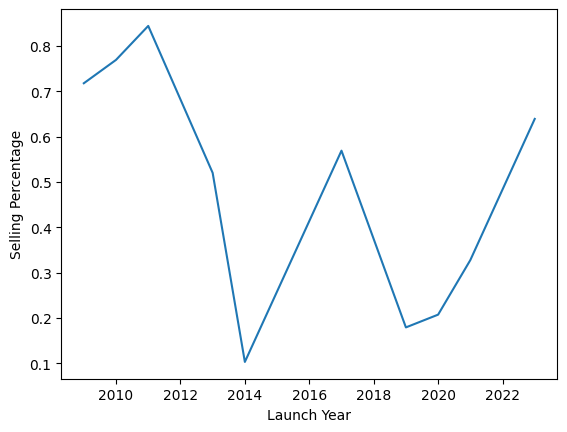

In [872]:
sale_progress_final.groupby('Launch Year').mean()['1st Year Sale Progress'].plot()
plt.ylabel('Selling Percentage')

In [873]:
sale_progress_final.to_csv('Sale Progress.csv')

## Real Estate Market Macro Data

In [874]:
# # import real estate macro market data
# MarketPriceIndex = pd.read_excel('/content/MarketPriceIndex_CCR.xlsx')
# MarketRentalIndex = pd.read_excel('/content/MarketRentalIndex_CCR.xlsx')
# VacancyRate = pd.read_excel('/content/MarketVaccancyRate.xlsx')
# UnitsSupply = pd.read_excel('/content/MarketUnitsSupply.xlsx')
# MacroMarket_data = MarketPriceIndex.merge(MarketRentalIndex, on = 'Quarter')
# MacroMarket_data = MacroMarket_data.merge(VacancyRate, on = 'Quarter')
# MacroMarket_data = MacroMarket_data.merge(UnitsSupply, on = 'Quarter')
# MacroMarket_data = MacroMarket_data.rename(columns ={'Core Central Region_x': 'Price Index', 'Core Central Region_y' : 'Rental Index', 'Number of Units' : 'Units Supply'})
# MacroMarket_data.to_csv('MacroMarket_Data.csv')

In [875]:
MacroMarket_data = pd.read_csv('/content/TimeSeriesData.csv')

In [876]:
MacroMarket_data['Quarter'] = pd.to_datetime(MacroMarket_data['Quarter'])
MacroMarket_data.set_index('Quarter', inplace = True)

In [877]:
MacroMarket_data = MacroMarket_data.resample('Q').last()

In [878]:
MacroMarket_data[MacroMarket_data.columns] = MacroMarket_data[MacroMarket_data.columns].astype('float')

In [879]:
MacroMarket_data

,Available Non-Landed Residential Units (NUMBER),Uncompleted Private Residential Units Launched for Sale in Core Central Region in the Quarter (NUMBER),Private Residential and Executive Condominium Units under Construction and Sold (NUMBER),Uncompleted Private Residential Units Sold in Core Central Region in the Quarter (NUMBER),Property Price Index of Non-Landed Residential Properties (INDEX),Property Price Index of Non-Landed Residential Properties in Core Central Region (INDEX),Rental Index of Non-Landed Properties (INDEX),Rental Index of Non-Landed Properties in Core Central Region (INDEX)
Quarter,,,,,,,,
2004-03-31,146985.0,187.0,13503.0,160.0,79.6,76.0,63.4,63.3
2004-06-30,149363.0,249.0,12657.0,151.0,79.6,76.1,63.5,63.5
2004-09-30,152154.0,107.0,11204.0,147.0,79.9,76.4,63.6,62.8
2004-12-31,154265.0,1131.0,10296.0,945.0,80.8,76.9,64.0,62.5
2005-03-31,156059.0,722.0,10425.0,596.0,81.4,77.6,64.7,63.3
...,...,...,...,...,...,...,...,...
2022-09-30,313769.0,240.0,37076.0,522.0,181.6,144.4,139.5,133.4
2022-12-31,317903.0,386.0,34534.0,351.0,182.1,145.4,150.0,143.1
2023-03-31,320706.0,146.0,32591.0,531.0,186.8,146.6,159.3,152.3


In [880]:
# !pip install pmdarima

In [881]:
# Use ARIMA Model to generate the next quater data
from pmdarima import auto_arima
value = []
for column in MacroMarket_data.columns:
    ARIMA_Model = auto_arima(MacroMarket_data[column], suppress_warnings = True)
    forecast, conf_int = ARIMA_Model.predict(n_periods=1, return_conf_int=True)
    next_value = forecast[0]
    value.append(next_value)

In [882]:
new_row = pd.Series(dict(zip(MacroMarket_data.columns, value)), name=pd.to_datetime('2024-1-1'))
MacroMarket_data = MacroMarket_data.append(new_row)

<ipython-input-882-64a8db6e49e8>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MacroMarket_data = MacroMarket_data.append(new_row)


In [883]:
MacroMarket_data_resampled = MacroMarket_data.resample('M').first().interpolate()

In [884]:
MacroMarket_data_resampled.index = MacroMarket_data_resampled.index - pd.offsets.MonthBegin(1)

In [885]:
MacroMarket_data_resampled['Price Index Gradient'] = MacroMarket_data_resampled['Property Price Index of Non-Landed Residential Properties (INDEX)'].pct_change()
MacroMarket_data_resampled['Price Index Gradient (CCR)'] = MacroMarket_data_resampled['Property Price Index of Non-Landed Residential Properties in Core Central Region (INDEX)'].pct_change()

In [886]:
MacroMarket_data_resampled

,Available Non-Landed Residential Units (NUMBER),Uncompleted Private Residential Units Launched for Sale in Core Central Region in the Quarter (NUMBER),Private Residential and Executive Condominium Units under Construction and Sold (NUMBER),Uncompleted Private Residential Units Sold in Core Central Region in the Quarter (NUMBER),Property Price Index of Non-Landed Residential Properties (INDEX),Property Price Index of Non-Landed Residential Properties in Core Central Region (INDEX),Rental Index of Non-Landed Properties (INDEX),Rental Index of Non-Landed Properties in Core Central Region (INDEX),Price Index Gradient,Price Index Gradient (CCR)
Quarter,,,,,,,,,,
2004-03-01,146985.000000,187.000000,13503.000000,160.000000,79.600000,76.000000,63.400000,63.300000,NaN,NaN
2004-04-01,147777.666667,207.666667,13221.000000,157.000000,79.600000,76.033333,63.433333,63.366667,0.000000,0.000439
2004-05-01,148570.333333,228.333333,12939.000000,154.000000,79.600000,76.066667,63.466667,63.433333,0.000000,0.000438
2004-06-01,149363.000000,249.000000,12657.000000,151.000000,79.600000,76.100000,63.500000,63.500000,0.000000,0.000438
2004-07-01,150293.333333,201.666667,12172.666667,149.666667,79.700000,76.200000,63.533333,63.266667,0.001256,0.001314
...,...,...,...,...,...,...,...,...,...,...
2023-09-01,333200.000000,210.000000,23466.000000,234.000000,189.800000,142.500000,163.300000,152.700000,0.007253,-0.009270
2023-10-01,333796.842949,214.481079,22583.129228,246.493821,191.047879,141.910676,162.649502,151.607987,0.006575,-0.004136
2023-11-01,334393.685897,218.962159,21700.258456,258.987641,192.295758,141.321353,161.999004,150.515975,0.006532,-0.004153


## Macro Economic Data and Interest Rate

In [887]:
Macro_Data = pd.read_excel('/content/Macro_Economic_Data.xlsx', parse_dates= True)
Macro_Data = Macro_Data.set_index('Year')

In [888]:
Macro_Data_1 = Macro_Data[[ 'Capital Inflow', 'CPI', 'GDP']]
Macro_Data_2 = Macro_Data[['Singaporean 2nd Property ABSD', 'Foreigner ABSD']]
# Interpolation of data
Macro_Data_1 = Macro_Data_1.resample('M').interpolate()
Macro_Data_2 = Macro_Data_2.resample('M').ffill()
Macro_Data_final = Macro_Data_1.merge(Macro_Data_2, left_index = True, right_index = True)
Macro_Data_final = Macro_Data_final.reset_index()
Macro_Data_final['Sale Month'] = Macro_Data_final['Year'].dt.to_period('M').dt.to_timestamp()
Macro_Data_final = Macro_Data_final.drop(columns = 'Year')

In [889]:
Macro_Data_final

,Capital Inflow,CPI,GDP,Singaporean 2nd Property ABSD,Foreigner ABSD,Sale Month
0,0.187033,0.744350,0.432862,0.0,0.0,2000-12-01
1,0.188358,0.744979,0.431476,0.0,0.0,2001-01-01
2,0.189682,0.745608,0.430091,0.0,0.0,2001-02-01
3,0.191007,0.746238,0.428705,0.0,0.0,2001-03-01
4,0.192332,0.746867,0.427319,0.0,0.0,2001-04-01
...,...,...,...,...,...,...
272,1.538031,1.108264,1.177579,0.2,0.6,2023-08-01
273,1.528523,1.111334,1.180276,0.2,0.6,2023-09-01
274,1.519016,1.114405,1.182974,0.2,0.6,2023-10-01
275,1.509508,1.117475,1.185671,0.2,0.6,2023-11-01


In [890]:
# Insert Interest Rate Data
Interest_Data = pd.read_csv('/content/Domestic Interest Rates .csv')
Interest_Data = Interest_Data[~(Interest_Data['Year'] == 'SORA Value Date')]

In [891]:
Interest_Data['Interest Rate'] = Interest_Data['Interest Rate'].astype('float')
Interest_Data = Interest_Data.ffill()
Interest_Data_Final = Interest_Data.groupby(['Year','Month']).mean()
Interest_Data_Final = Interest_Data_Final[['Interest Rate']].reset_index()

In [892]:
Interest_Data_Final['Sale Month String'] = Interest_Data_Final['Year'].astype(str) + '-' + Interest_Data_Final['Month']
Interest_Data_Final = Interest_Data_Final[['Sale Month String', 'Interest Rate']]
Interest_Data_Final['Sale Date'] = pd.to_datetime(Interest_Data_Final['Sale Month String']) #, format='%Y-%b')
# Interest_Data_Final['Sale Month'] = Interest_Data_Final['Sale Date'].dt.to_period('M')
Interest_Data_Final = Interest_Data_Final.drop(columns = ['Sale Month String'])

In [893]:
Interest_Data_Final

,Interest Rate,Sale Date
0,6.548421,2000-12-01
1,4.622500,2001-04-01
2,3.562727,2001-08-01
3,1.926316,2001-12-01
4,5.354000,2001-02-01
...,...,...
272,3.348539,2023-03-01
273,3.611373,2023-05-01
274,3.753676,2023-11-01
275,3.717009,2023-10-01


## Merge the datas

In [894]:
data_merged = data.merge(MacroMarket_data_resampled, left_on = 'Sale Month', right_index = True, how = 'left')

In [961]:
data_merged

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Tenure,Completion Date,Postal District,Postal Sector,...,GDP,Singaporean 2nd Property ABSD,Foreigner ABSD,Interest Rate,Sale Date_y,Lease Commencement,Total Tenure,Remianing Tenure,Level Intermidiate,Level
0,PARK INFINIA AT WEE NAM,"1,103,000","1,001.05","1,102",06-Mar-09,2A LINCOLN ROAD #14-07,Freehold,2008,11,30,...,0.634513,0.0,0.0,0.206173,2009-03-01,0.0,999,999.0,#14-07,14.0
1,PARK INFINIA AT WEE NAM,"1,220,000","1,001.05","1,219",12-Mar-09,2A LINCOLN ROAD #24-07,Freehold,2008,11,30,...,0.634513,0.0,0.0,0.206173,2009-03-01,0.0,999,999.0,#24-07,24.0
2,PARK INFINIA AT WEE NAM,"1,139,000","1,001.05","1,138",13-Mar-09,2A LINCOLN ROAD #22-07,Freehold,2008,11,30,...,0.634513,0.0,0.0,0.206173,2009-03-01,0.0,999,999.0,#22-07,22.0
3,PARK INFINIA AT WEE NAM,"1,902,000","1,463.90","1,299",20-Mar-09,2A LINCOLN ROAD #02-08,Freehold,2008,11,30,...,0.634513,0.0,0.0,0.206173,2009-03-01,0.0,999,999.0,#02-08,2.0
4,THE SUITES AT CENTRAL,"908,262",635.08,"1,430",20-Mar-09,57A DEVONSHIRE ROAD #19-02,Freehold,2009,9,23,...,0.634513,0.0,0.0,0.206173,2009-03-01,0.0,999,999.0,#19-02,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10126,WATTEN HOUSE,"14,391,000","4,079.56","3,520",14-Dec-23,46 SHELFORD ROAD #05-27,Freehold,Uncompleted,11,28,...,1.188368,0.2,0.6,3.735260,2023-12-01,0.0,999,999.0,#05-27,5.0
10127,CUSCADEN RESERVE,"3,537,000",936.47,"3,777",17-Dec-23,8 CUSCADEN ROAD #23-06,99 yrs from 14/08/2018,2023,10,24,...,1.188368,0.2,0.6,3.735260,2023-12-01,6.0,99,93.0,#23-06,23.0
10128,WATTEN HOUSE,"6,054,000","1,851.41","3,270",18-Dec-23,38 SHELFORD ROAD #01-09,Freehold,Uncompleted,11,28,...,1.188368,0.2,0.6,3.735260,2023-12-01,0.0,999,999.0,#01-09,1.0
10129,WATTEN HOUSE,"4,976,000","1,539.25","3,233",22-Dec-23,44 SHELFORD ROAD #02-20,Freehold,Uncompleted,11,28,...,1.188368,0.2,0.6,3.735260,2023-12-01,0.0,999,999.0,#02-20,2.0


In [896]:
data_merged = data_merged.merge(sale_progress_final, left_on = 'Project Name', right_index = True, how = 'left')

In [897]:
data_merged = data_merged.merge(Macro_Data_final, left_on = 'Sale Month', right_on = 'Sale Month', how = 'left')

In [898]:
data_merged = data_merged.merge(Interest_Data_Final, left_on = 'Sale Month', right_on = 'Sale Date', how = 'left')

In [899]:
data_merged = data_merged[~(data_merged['Tenure'] == '99 years leasehold')]

## Find the tenure and level

In [900]:
# calculate lease tenure
data_merged['Lease Commencement'] = data_merged['Tenure'].str.split(' ').str[-1].str.split('/').str[-1]
data_merged['Lease Commencement'].replace({'Freehold':'2024', '1875':'2024', '1877':'2024', '1841':'2024'},inplace = True)
data_merged['Lease Commencement'] = 2024 - data_merged['Lease Commencement'].astype('float')

In [901]:
data_merged['Total Tenure'] = np.where(data_merged['Tenure'].isin(['Freehold', '1875', '1877', '1841']), 999, 99)
data_merged['Remianing Tenure'] = data_merged['Total Tenure'] - data_merged['Lease Commencement']
data_merged['Remianing Tenure'].unique()

array([999.,  99.,  83.,  76.,  81.,  85.,  87.,  88.,  91.,  93.])

In [902]:
data_merged.rename(columns = {'Sale Date_x' : 'Sale Date'}, inplace = True)

In [903]:
data_merged['Sale Year'] = data_merged['Sale Year'].astype('int')

In [904]:
data_merged['Level Intermidiate'] = data_merged['Address'].str.split(' ').str[-1]
data_merged['Level'] = np.where(data_merged['Level Intermidiate'] == 'ETC', data_merged['Address'].str.split(' ').str[-2], data_merged['Level Intermidiate'])

In [905]:
data_merged['Level'] = data_merged['Level'].str.split('-').str[0].str.replace('#', '')
data_merged['Level'] = data_merged['Level'].replace({'ROAD' : 1})

In [906]:
data_merged['Level'] = data_merged['Level'].astype('float')

In [907]:
data_merged['Level'].unique()

array([14., 24., 22.,  2., 19., 27., 28., 26., 10.,  7., 31., 12.,  8.,
       23.,  4.,  3.,  9., 11.,  5., 18., 13., 16., 15., 21.,  6., 17.,
       20.,  1., 29., 30., 25., 33., 34., 35., 32., 36.])

In [908]:
# Check NA element
data_check = data_merged[data_merged['Project Name'] == 'WATTEN HOUSE']
np.sum(data_check.isna())

Project Name            0
Transacted Price ($)    0
Area (SQFT)             0
Unit Price ($ PSF)      0
Sale Date               0
                       ..
Lease Commencement      0
Total Tenure            0
Remianing Tenure        0
Level Intermidiate      0
Level                   0
Length: 109, dtype: int64

In [909]:
Residencial_Analysis_Data = data_merged.dropna()

In [910]:
Residencial_Analysis_Data.columns

Index(['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Sale Date', 'Address', 'Tenure',
       'Completion Date', 'Postal District', 'Postal Sector',
       ...
       'GDP', 'Singaporean 2nd Property ABSD', 'Foreigner ABSD',
       'Interest Rate', 'Sale Date_y', 'Lease Commencement', 'Total Tenure',
       'Remianing Tenure', 'Level Intermidiate', 'Level'],
      dtype='object', length=109)

In [911]:
Residential_Data = Residencial_Analysis_Data[['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Sale Date', 'Address', 'Tenure',
       'Completion Date', 'Postal District', 'Postal Sector', 'min_distance_to_mrt',
       'min_distance_to_star_school', 'Room Type', 'Sale Year', 'Sale Month',
       'Earliest Sale Month','Available Non-Landed Residential Units (NUMBER)',
       'Uncompleted Private Residential Units Launched for Sale in Core Central Region in the Quarter (NUMBER)',
       'Private Residential and Executive Condominium Units under Construction and Sold (NUMBER)',
       'Uncompleted Private Residential Units Sold in Core Central Region in the Quarter (NUMBER)',
       'Property Price Index of Non-Landed Residential Properties (INDEX)',
       'Property Price Index of Non-Landed Residential Properties in Core Central Region (INDEX)',
       'Rental Index of Non-Landed Properties (INDEX)',
       'Rental Index of Non-Landed Properties in Core Central Region (INDEX)',
       'Price Index Gradient', 'Price Index Gradient (CCR)', '1st Year Sale Progress',
       '2nd Year Sale Progress', '3rd Year Sale Progress',
       '4th Year Sale Progress', '5th Year Sale Progress', 'Sum',
       'Capital Inflow', 'CPI', 'GDP',
       'Singaporean 2nd Property ABSD', 'Foreigner ABSD', 'Interest Rate','Remianing Tenure','Level']]

In [912]:
Residential_Data['Unit Price ($ PSF)'] = Residential_Data['Unit Price ($ PSF)'].str.replace(',','').astype('float')

<ipython-input-912-22937aadc6ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Residential_Data['Unit Price ($ PSF)'] = Residential_Data['Unit Price ($ PSF)'].str.replace(',','').astype('float')


In [913]:
Residential_Data.to_csv('Residential_Data.csv')

## Check the Feature Importances

In [914]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge

In [915]:
X = Residential_Data[['Postal Sector', 'min_distance_to_mrt','min_distance_to_star_school', 'Room Type', 'Available Non-Landed Residential Units (NUMBER)',
       'Uncompleted Private Residential Units Launched for Sale in Core Central Region in the Quarter (NUMBER)',
       'Private Residential and Executive Condominium Units under Construction and Sold (NUMBER)',
       'Uncompleted Private Residential Units Sold in Core Central Region in the Quarter (NUMBER)',
       'Property Price Index of Non-Landed Residential Properties (INDEX)',
       'Property Price Index of Non-Landed Residential Properties in Core Central Region (INDEX)',
       'Rental Index of Non-Landed Properties (INDEX)',
       'Rental Index of Non-Landed Properties in Core Central Region (INDEX)',
       'Price Index Gradient', 'Price Index Gradient (CCR)', 'Capital Inflow', 'CPI', 'GDP',
       'Singaporean 2nd Property ABSD', 'Foreigner ABSD', 'Interest Rate','Remianing Tenure','Level' ]].astype('float')
y = Residential_Data[['1st Year Sale Progress']]

In [916]:
X.columns.to_frame()

,0
Postal Sector,Postal Sector
min_distance_to_mrt,min_distance_to_mrt
min_distance_to_star_school,min_distance_to_star_school
Room Type,Room Type
Available Non-Landed Residential Units (NUMBER),Available Non-Landed Residential Units (NUMBER)
Uncompleted Private Residential Units Launched for Sale in Core Central Region in the Quarter (NUMBER),Uncompleted Private Residential Units Launched...
Private Residential and Executive Condominium Units under Construction and Sold (NUMBER),Private Residential and Executive Condominium ...
Uncompleted Private Residential Units Sold in Core Central Region in the Quarter (NUMBER),Uncompleted Private Residential Units Sold in ...
Property Price Index of Non-Landed Residential Properties (INDEX),Property Price Index of Non-Landed Residential...
Property Price Index of Non-Landed Residential Properties in Core Central Region (INDEX),Property Price Index of Non-Landed Residential...


In [917]:
# Random Forest
RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X,y)
Score_RF_train = RF.score(X,y)
print('Training R score of Random Forest', Score_RF_train)

<ipython-input-917-304f5f0034fd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X,y)


Training R score of Random Forest 0.9981688073378988


Text(0.5, 1.0, 'Feature Importance for Sale Progress')

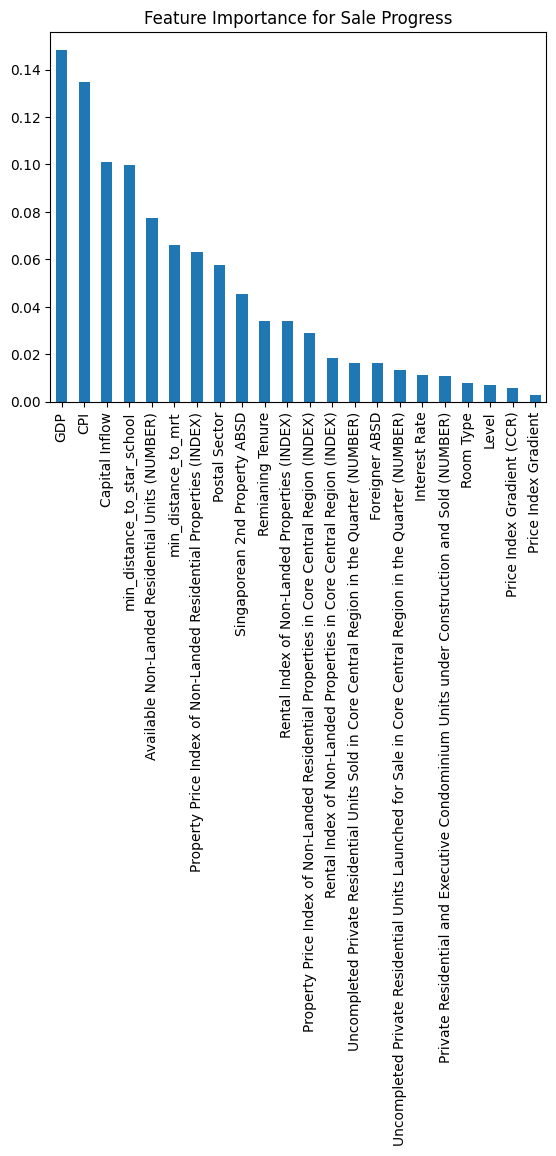

In [918]:
# Calculate Importance
importances = RF.feature_importances_
forest_importance = pd.Series(importances, index = X.columns)
forest_importance = forest_importance.sort_values(ascending = False)
forest_importance.plot.bar()
plt.title('Feature Importance for Sale Progress')

In [919]:
y_price = Residential_Data['Unit Price ($ PSF)']
# Random Forest
RF_price=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X,y_price)
Score_RF_train_price = RF_price.score(X,y_price)
print('Training R score of Random Forest', Score_RF_train_price)

Training R score of Random Forest 0.9809821756035619


Text(0.5, 1.0, 'Feature Importance for Sale Price')

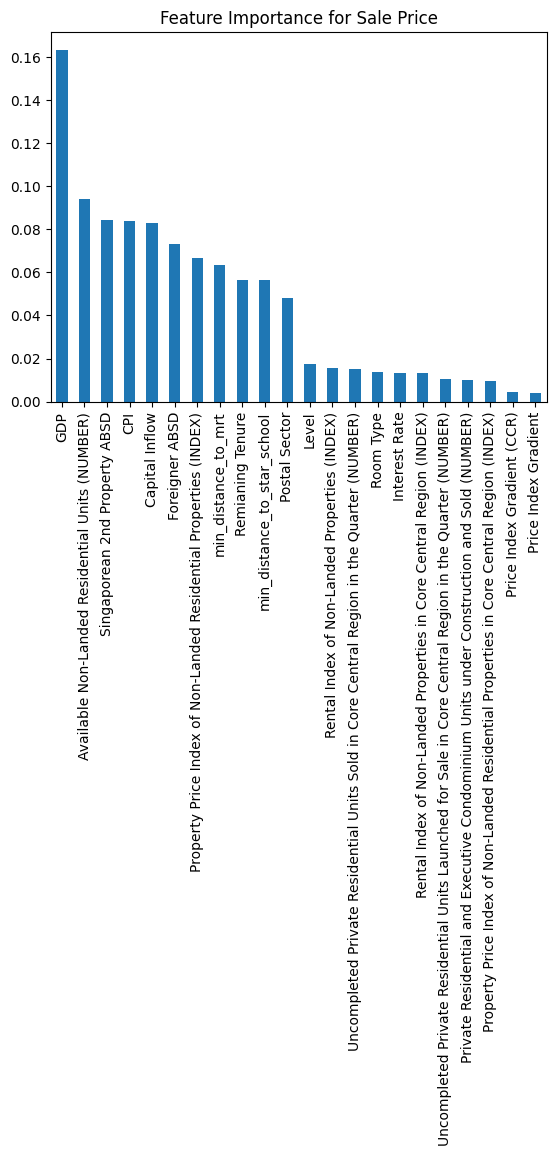

In [920]:
# Calculate Importance
importances = RF_price.feature_importances_
forest_importance = pd.Series(importances, index = X.columns)
forest_importance = forest_importance.sort_values(ascending = False)
forest_importance.plot.bar()
plt.title('Feature Importance for Sale Price')

In [921]:
Ridge_ML=Ridge(alpha=0.2).fit(X,y_price)
Score_Ridge_train = Ridge_ML.score(X,y_price)
print('Training R score of Ridge', Score_Ridge_train)

Training R score of Ridge 0.8387525582554376


## Machine Learning for sale progress

In [922]:
# using LinearRegression, Ridge, Lasso, RandomForest, GradientBoostingTree,NaiveBayes,SVM and NeuralNetwork
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [923]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 0)

In [924]:
# Linear Regression
lr=LinearRegression().fit(X_train,y_train)
Score_linear_train = lr.score(X_train,y_train)
Score_linear_test = lr.score(X_test,y_test)
print('Training R score of linear regression', Score_linear_train)
print('Testing R score of linear regression', Score_linear_test)

Training R score of linear regression 0.7779411733876682
Testing R score of linear regression 0.7878116935828978


In [925]:
# Ridge
Ridge_ML=Ridge(alpha=0.2).fit(X_train,y_train)
Score_Ridge_train = Ridge_ML.score(X_train,y_train)
Score_Ridge_test = Ridge_ML.score(X_test,y_test)
print('Training R score of Ridge', Score_Ridge_train)
print('Testing R score of Ridge', Score_Ridge_test)

Training R score of Ridge 0.7653016555805655
Testing R score of Ridge 0.7714812701944982


In [926]:
# Lasso
Lasso_ML=Lasso(alpha=0.2).fit(X_train,y_train)
Score_Lasso_train = Lasso_ML.score(X_train,y_train)
Score_Lasso_test = Lasso_ML.score(X_test,y_test)
print('Training R score of Lasso', Score_Lasso_train)
print('Testing R score of Lasso', Score_Lasso_test)

Training R score of Lasso 0.6705255630793854
Testing R score of Lasso 0.6646284917558659


In [927]:
# Random Forest
RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X_train,y_train)
Score_RF_train = RF.score(X_train,y_train)
Score_RF_test = RF.score(X_test,y_test)
print('Training R score of Random Forest', Score_RF_train)
print('Testing R score of Random Forest', Score_RF_test)

<ipython-input-927-5bf91fdd5f71>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X_train,y_train)


Training R score of Random Forest 0.9983766035675021
Testing R score of Random Forest 0.9961567074764915


In [928]:
# Gradient Boosted Tree
GB = GradientBoostingRegressor(n_estimators= 500, random_state = 0, max_features='sqrt', learning_rate= 0.01, max_depth = 10)
GB.fit(X_train, y_train)
Score_GB_train = GB.score(X_train,y_train)
Score_GB_test = GB.score(X_test,y_test)
print('Training R score of Gradient Boosted Tree', Score_GB_train)
print('Testing R score of Gradient Boosted Tree', Score_GB_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training R score of Gradient Boosted Tree 0.9999410924337326
Testing R score of Gradient Boosted Tree 0.9976119720627855


In [929]:
# For Prediction
GB_sale_progress = GradientBoostingRegressor(n_estimators= 500, random_state = 0, max_features='sqrt', learning_rate= 0.01, max_depth = 10)
GB_sale_progress.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.01, max_depth=10, max_features='sqrt',
                          n_estimators=500, random_state=0)

In [930]:
# SVM (poly)
svm1 = svm.SVR(kernel = 'poly', C = 1.0)
svm1.fit(X_train, y_train)
Score_SVM1_train = svm1.score(X_train,y_train)
Score_SVM1_test = svm1.score(X_test,y_test)
print('Training R score of SVM (poly)', Score_SVM1_train)
print('Testing R score of SVM (poly)', Score_SVM1_test)
# SVM (Gaussian)
svm2 = svm.SVR(kernel = 'rbf', C = 1.0, gamma = 'scale')
svm2.fit(X_train, y_train)
Score_SVM2_train = svm2.score(X_train,y_train)
Score_SVM2_test = svm2.score(X_test,y_test)
print('Training R score of SVM (Gaussian)', Score_SVM2_train)
print('Testing R score of SVM (Gaussian)', Score_SVM2_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training R score of SVM (poly) 0.5618528272204019
Testing R score of SVM (poly) 0.561844739582342


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training R score of SVM (Gaussian) 0.6184162584415787
Testing R score of SVM (Gaussian) 0.6060091125364059


In [931]:
# Neural Network
NN = tf.keras.models.Sequential()
NN.add(tf.keras.layers.Dense(units = 4, activation = 'sigmoid'))
NN.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
NN.compile(optimizer = 'adam', loss = 'mean_absolute_error')
result = NN.fit(X_train, y_train, batch_size = 50, epochs = 100)

Epoch 1/100
113/113 [==============================] - 1s 2ms/step - loss: 0.2844
Epoch 2/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2738
Epoch 3/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2680
Epoch 4/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2624
Epoch 5/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2567
Epoch 6/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2511
Epoch 7/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2465
Epoch 8/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2456
Epoch 9/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2452
Epoch 10/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2448
Epoch 11/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2444
Epoch 12/100
113/113 [==============================] - 0s 2ms/step - loss: 0.2440
Epoch 13/100


In [932]:
y_train_pred = NN.predict(X_train)
y_test_pred = NN.predict(X_test)
r2_value_train = r2_score(y_train, y_train_pred)
r2_value_test = r2_score(y_test, y_test_pred)
print(f'R2 Score on training data: {r2_value_train}')
print(f'R2 Score on testing data: {r2_value_test}')

44/44 [==============================] - 0s 2ms/step
R2 Score on training data: -0.42118673138520046
R2 Score on testing data: -0.43777975384943013


In [933]:
print('Training R score of linear regression', Score_linear_train)
print('Testing R score of linear regression', Score_linear_test)
print('Training R score of Ridge', Score_Ridge_train)
print('Testing R score of Ridge', Score_Ridge_test)
print('Training R score of Lasso', Score_Lasso_train)
print('Testing R score of Lasso', Score_Lasso_test)
print('Training R score of Random Forest', Score_RF_train)
print('Testing R score of Random Forest', Score_RF_test)
# print('Training R score of Naive Bayes', Score_NB_train)
# print('Testing R score of Naive Bayes', Score_NB_test)
print('Training R score of Gradient Boosted Tree', Score_GB_train)
print('Testing R score of Gradient Boosted Tree', Score_GB_test)
print('Training R score of SVM (poly)', Score_SVM1_train)
print('Testing R score of SVM (poly)', Score_SVM1_test)
print('Training R score of SVM (Gaussian)', Score_SVM2_train)
print('Testing R score of SVM (Gaussian)', Score_SVM2_test)
print(f'R2 Score on training data: {r2_value_train}')
print(f'R2 Score on testing data: {r2_value_test}')

Training R score of linear regression 0.7779411733876682
Testing R score of linear regression 0.7878116935828978
Training R score of Ridge 0.7653016555805655
Testing R score of Ridge 0.7714812701944982
Training R score of Lasso 0.6705255630793854
Testing R score of Lasso 0.6646284917558659
Training R score of Random Forest 0.9983766035675021
Testing R score of Random Forest 0.9961567074764915
Training R score of Gradient Boosted Tree 0.9999410924337326
Testing R score of Gradient Boosted Tree 0.9976119720627855
Training R score of SVM (poly) 0.5618528272204019
Testing R score of SVM (poly) 0.561844739582342
Training R score of SVM (Gaussian) 0.6184162584415787
Testing R score of SVM (Gaussian) 0.6060091125364059
R2 Score on training data: -0.42118673138520046
R2 Score on testing data: -0.43777975384943013


## Machine Learning for Sale Price

In [934]:
X_train, X_test, y_train, y_test = train_test_split(X,y_price, test_size = 0.2, random_state= 0)

In [935]:
# Linear Regression
lr=LinearRegression().fit(X_train,y_train)
Score_linear_train = lr.score(X_train,y_train)
Score_linear_test = lr.score(X_test,y_test)
print('Training R score of linear regression', Score_linear_train)
print('Testing R score of linear regression', Score_linear_test)

Training R score of linear regression 0.8374843067662501
Testing R score of linear regression 0.8436509514977009


In [936]:
# Ridge
Ridge_ML=Ridge(alpha=0.2).fit(X_train,y_train)
Score_Ridge_train = Ridge_ML.score(X_train,y_train)
Score_Ridge_test = Ridge_ML.score(X_test,y_test)
print('Training R score of Ridge', Score_Ridge_train)
print('Testing R score of Ridge', Score_Ridge_test)

Training R score of Ridge 0.8373810871249635
Testing R score of Ridge 0.8434476627608138


In [937]:
# Lasso
Lasso_ML=Lasso(alpha=0.2).fit(X_train,y_train)
Score_Lasso_train = Lasso_ML.score(X_train,y_train)
Score_Lasso_test = Lasso_ML.score(X_test,y_test)
print('Training R score of Lasso', Score_Lasso_train)
print('Testing R score of Lasso', Score_Lasso_test)

Training R score of Lasso 0.8363577465255426
Testing R score of Lasso 0.8413524844658984


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e+08, tolerance: 2.315e+05
  model = cd_fast.enet_coordinate_descent(


In [938]:
# Random Forest
RF=RandomForestRegressor(n_estimators=100,random_state=0,max_features = 'sqrt', max_depth=10).fit(X_train,y_train)
Score_RF_train = RF.score(X_train,y_train)
Score_RF_test = RF.score(X_test,y_test)
print('Training R score of Random Forest', Score_RF_train)
print('Testing R score of Random Forest', Score_RF_test)

Training R score of Random Forest 0.9818292937011058
Testing R score of Random Forest 0.968637758503792


In [939]:
# Gradient Boosted Tree
GB = GradientBoostingRegressor(n_estimators= 500, random_state = 0, max_features='sqrt', learning_rate= 0.01, max_depth = 10)
GB.fit(X_train, y_train)
Score_GB_train = GB.score(X_train,y_train)
Score_GB_test = GB.score(X_test,y_test)
print('Training R score of Gradient Boosted Tree', Score_GB_train)
print('Testing R score of Gradient Boosted Tree', Score_GB_test)

Training R score of Gradient Boosted Tree 0.9941476971968386
Testing R score of Gradient Boosted Tree 0.9776712964796095


In [940]:
# For Prediction
GB_sale_price = GradientBoostingRegressor(n_estimators= 500, random_state = 0, max_features='sqrt', learning_rate= 0.01, max_depth = 10)
GB_sale_price.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, max_features='sqrt',
                          n_estimators=500, random_state=0)

In [941]:
# SVM (poly)
svm1 = svm.SVR(kernel = 'poly', C = 1.0)
svm1.fit(X_train, y_train)
Score_SVM1_train = svm1.score(X_train,y_train)
Score_SVM1_test = svm1.score(X_test,y_test)
print('Training R score of SVM (poly)', Score_SVM1_train)
print('Testing R score of SVM (poly)', Score_SVM1_test)
# SVM (Gaussian)
svm2 = svm.SVR(kernel = 'rbf', C = 1.0, gamma = 'scale')
svm2.fit(X_train, y_train)
Score_SVM2_train = svm2.score(X_train,y_train)
Score_SVM2_test = svm2.score(X_test,y_test)
print('Training R score of SVM (Gaussian)', Score_SVM2_train)
print('Testing R score of SVM (Gaussian)', Score_SVM2_test)

Training R score of SVM (poly) 0.6306130147372906
Testing R score of SVM (poly) 0.6246907891982703
Training R score of SVM (Gaussian) 0.4818932426016692
Testing R score of SVM (Gaussian) 0.48592265035215465


In [942]:
# Neural Network
NN = tf.keras.models.Sequential()
NN.add(tf.keras.layers.Dense(units = 8, activation = 'sigmoid'))
NN.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
NN.compile(optimizer = 'adam', loss = 'mean_absolute_error')
result = NN.fit(X_train, y_train, batch_size = 50, epochs = 100)

Epoch 1/100
113/113 [==============================] - 1s 2ms/step - loss: 2116.9668
Epoch 2/100
113/113 [==============================] - 0s 2ms/step - loss: 2116.8523
Epoch 3/100
113/113 [==============================] - 0s 2ms/step - loss: 2116.7473
Epoch 4/100
113/113 [==============================] - 0s 2ms/step - loss: 2116.6631
Epoch 5/100
113/113 [==============================] - 0s 2ms/step - loss: 2116.5996
Epoch 6/100
113/113 [==============================] - 0s 3ms/step - loss: 2116.5547
Epoch 7/100
113/113 [==============================] - 0s 3ms/step - loss: 2116.5229
Epoch 8/100
113/113 [==============================] - 0s 3ms/step - loss: 2116.4993
Epoch 9/100
113/113 [==============================] - 0s 3ms/step - loss: 2116.4827
Epoch 10/100
113/113 [==============================] - 0s 3ms/step - loss: 2116.4675
Epoch 11/100
113/113 [==============================] - 0s 2ms/step - loss: 2116.4602
Epoch 12/100
113/113 [==============================] - 0s 3ms/

In [943]:
y_train_pred = NN.predict(X_train)
y_test_pred = NN.predict(X_test)
r2_value_train = r2_score(y_train, y_train_pred)
r2_value_test = r2_score(y_test, y_test_pred)
print(f'R2 Score on training data: {r2_value_train}')
print(f'R2 Score on testing data: {r2_value_test}')

44/44 [==============================] - 0s 2ms/step
R2 Score on training data: -10.890745348039387
R2 Score on testing data: -11.892112443980805


In [944]:
print('Training R score of linear regression', Score_linear_train)
print('Testing R score of linear regression', Score_linear_test)
print('Training R score of Ridge', Score_Ridge_train)
print('Testing R score of Ridge', Score_Ridge_test)
print('Training R score of Lasso', Score_Lasso_train)
print('Testing R score of Lasso', Score_Lasso_test)
print('Training R score of Random Forest', Score_RF_train)
print('Testing R score of Random Forest', Score_RF_test)
# print('Training R score of Naive Bayes', Score_NB_train)
# print('Testing R score of Naive Bayes', Score_NB_test)
print('Training R score of Gradient Boosted Tree', Score_GB_train)
print('Testing R score of Gradient Boosted Tree', Score_GB_test)
print('Training R score of SVM (poly)', Score_SVM1_train)
print('Testing R score of SVM (poly)', Score_SVM1_test)
print('Training R score of SVM (Gaussian)', Score_SVM2_train)
print('Testing R score of SVM (Gaussian)', Score_SVM2_test)
print(f'R2 Score on training data: {r2_value_train}')
print(f'R2 Score on testing data: {r2_value_test}')

Training R score of linear regression 0.8374843067662501
Testing R score of linear regression 0.8436509514977009
Training R score of Ridge 0.8373810871249635
Testing R score of Ridge 0.8434476627608138
Training R score of Lasso 0.8363577465255426
Testing R score of Lasso 0.8413524844658984
Training R score of Random Forest 0.9818292937011058
Testing R score of Random Forest 0.968637758503792
Training R score of Gradient Boosted Tree 0.9941476971968386
Testing R score of Gradient Boosted Tree 0.9776712964796095
Training R score of SVM (poly) 0.6306130147372906
Testing R score of SVM (poly) 0.6246907891982703
Training R score of SVM (Gaussian) 0.4818932426016692
Testing R score of SVM (Gaussian) 0.48592265035215465
R2 Score on training data: -10.890745348039387
R2 Score on testing data: -11.892112443980805


## Prediction

In [945]:
loc_lat = 1.291899
loc_lng = 103.841475
min_distance = float('inf')
for mrt_index, mrt_row in mrt.iterrows():
    mrt_lat = mrt_row['lat']
    mrt_lng = mrt_row['lng']
    distance = haversine(loc_lat, loc_lng, mrt_lat, mrt_lng)
    if distance < min_distance:
        min_distance = distance
min_distance

0.3509976670959466

In [946]:
loc_lat = 1.291899
loc_lng = 103.841475
min_distance = float('inf')
for school_index, school_row in school_loc.iterrows():
    school_lat = school_row['LATITUDE']
    school_lng = school_row['LONGITUDE']
    distance = haversine(loc_lat, loc_lng, school_lat, school_lng)
    if distance < min_distance:
        min_distance = distance
min_distance

3.014851535564376

In [947]:
# Use ARIMA Model to generate the 2025Q1 quater data
from pmdarima import auto_arima
value = []
value_preceding = []
for column in MacroMarket_data.columns:
    ARIMA_Model = auto_arima(MacroMarket_data[column], suppress_warnings = True)
    forecast, conf_int = ARIMA_Model.predict(n_periods=5, return_conf_int=True)
    next_value = forecast[84]
    next_value_preceding = forecast[83]
    value.append(next_value)
    value_preceding.append(next_value_preceding)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

In [948]:
value_preceding

[345136.85897435906,
 227.9557518360206,
 9414.028183779152,
 344.19115014674225,
 200.59608527276845,
 139.219186441392,
 149.02195834610467,
 139.2906635893101]

In [949]:
input_data = pd.Series(dict(zip(MacroMarket_data.columns, value)), name=pd.to_datetime('2025-01-01'))

In [950]:
input_data['Price Index Gradiet'] = value[4] - value_preceding[4]
input_data['Price Index Gradiet (CCR)'] = value[5] - value_preceding[5]

In [951]:
input_data

Available Non-Landed Residential Units (NUMBER)                                                           347524.230769
Uncompleted Private Residential Units Launched for Sale in Core Central Region in the Quarter (NUMBER)       227.955752
Private Residential and Executive Condominium Units under Construction and Sold (NUMBER)                    8515.465462
Uncompleted Private Residential Units Sold in Core Central Region in the Quarter (NUMBER)                    347.337129
Property Price Index of Non-Landed Residential Properties (INDEX)                                            202.047398
Property Price Index of Non-Landed Residential Properties in Core Central Region (INDEX)                     139.214921
Rental Index of Non-Landed Properties (INDEX)                                                                149.474060
Rental Index of Non-Landed Properties in Core Central Region (INDEX)                                         139.237671
Price Index Gradiet                     

In [952]:
input = pd.read_excel('/content/Input_Features_for_Unity.xlsx',index_col='Features')

In [953]:
prediction = np.array(input.values.squeeze())

In [954]:
prediction = prediction.reshape(-1,1)

In [955]:
prediction = prediction.transpose()

In [956]:
prediction

array([[ 2.300000e+01,  3.509970e-01,  3.014850e+00,  2.000000e+00,
         3.499120e+05,  2.280000e+02,  8.267000e+03,  3.490000e+02,
         2.030000e+02,  1.390000e+02,  1.510000e+02,  1.390000e+02,
         1.450000e+00, -1.000000e-02,  1.500000e+00,  1.158597e+00,
         1.211760e+00,  2.000000e-01,  6.000000e-01,  3.500000e+00,
         9.990000e+02,  5.000000e+00]])

In [957]:
Progress = GB_sale_progress.predict(prediction)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [958]:
Progress

array([0.35952225])

In [959]:
price = GB_sale_price.predict(prediction)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [960]:
price

array([3081.63840349])